# Práctica de “Modelos lineales generalizados

<br>
<h4 align="right">Armando Olivares<h4>

El set de datos adult.csv que se proporciona contiene información del censo de los EEUU correspondiente al año 1994. Concretamente, el set de datos presenta información demográﬁca (edad, nivel de estudios, estado civil...) relativa a más de 30.000 individuos junto con una variable objetivo salary que queremos predecir: si su salario es inferior o superior a 50.000 dólares anuales. El set de datos está tomado de aquí, donde puedes consultar su documentación. 

a) Después de eliminar la variable fnlwgt, realiza un análisis exploratorio del set de datos. Aplica las técnicas de preprocesado que consideres oportunas y establece algunas hipótesis acerca de la relación entre salary y los predictores.

## Preliminar

Cargamos las librerías y fijamos el seed.

In [319]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import seaborn as sn
np.random.seed(12345)

### Data loading

In [320]:
adult = pd.read_csv('adult.csv', sep = ',', na_values=" ?")
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Eliminamos la variable *fnlwgt*

In [321]:
adult.drop(["fnlwgt"], axis=1, inplace=True)


Revisamos las NA's'

In [322]:
pd.isnull(adult).sum()

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
salary               0
dtype: int64

Como podemos notar existen NA's en la columna *workclass*, en *occupation* y en *native-country*, todas columnas categóricas por que decidimos imputar a la moda de los valores:

In [323]:
adult = adult.apply(lambda x: x.fillna(x.mode()[0]),axis=0)

#### Estadísticos básicos 

In [324]:
print(adult.shape)
print(adult.describe())
print(adult.dtypes)

(32561, 14)
                age  education-num  capital-gain  capital-loss  hours-per-week
count  32561.000000   32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581647      10.080679   1077.648844     87.303830       40.437456
std       13.640433       2.572720   7385.292085    402.960219       12.347429
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       48.000000      12.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000
age                int64
workclass         object
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
ho

In [325]:
names = list(adult.select_dtypes(exclude=[np.number]).columns)
for row in names:
    print("------ "+row+ "-----")
    print (adult[row].value_counts())
    print("\n")

------ workclass-----
 Private             24532
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64


------ education-----
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64


------ marital-status-----
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64


------ occupation---

Esto no da una idea, de como de distribuido/balanceado están los datos en Nuestro Dataset 

## Estudio de Relación entre las variables predictoras y a predecir

Lo primero que debemos señalar es que nuestro dataset se compone mayormente de variables categóricas, por lo que visualizaremos las distribuciones y su relación con la variable  *salary* con la ayuda de Gráficos de Violin (violin plots) del paquete seaborn

Primero Recodificamos algunas variables para poder representarlas en el gráfico:

In [326]:
recoding = {"sex":     {1: "Female", 2: " Male"},
                "marital-status": {1: "Married-civ-spouse", 2: "Married-spouse-absent", 3: "Divorced", 4: "Widowed ",
                                  5:  "Never-married", 6: "Married-AF-spouse" },
                "education": {1: " HS-grad", 2: " Some-college", 3: " Bachelors", 4: " Masters",
                                  5:  " Assoc-voc", 6:" 11th", 7: " Assoc-acdm", 8: " Prof-school", 9: " 9th", 10: " 12th",
                             11: " Doctorate", 12: " 7th-8th", 13: " 5th-6th", 14:"1st-4th", 15: "Preschool" , 16: " 10th"},
             "occupation": {1: " Prof-specialty", 2: " Sales", 3: " Craft-repair", 4: " Exec-managerial",
                                  5:  "Adm-clerical", 6:"Other-service",   7:  "Machine-op-inspct", 8:"Transport-moving", 9:"Transport-moving",
                           10: "Handlers-cleaners", 11: "Farming-fishing", 12: "Tech-support", 13:"Protective-serv", 14: "Priv-house-serv", 
                           15: "Armed-Forces"},
            "relationship": {1: "Husband", 2: "Not-in-family", 3: "Own-child", 4: "Unmarried",
                                  5:  "Wife", 6: "Other-relative" },
            "race": {1: "White", 2: "Asian-Pac-Islander", 3: "Black", 4: "Amer-Indian-Eskimo",
                                 5:  "Other" },
            "salary": {  " <=50K": 0, " >50K": 1}
           }
adult_sns = adult.replace(recoding)
adult_sns.drop(["native-country"], axis=1, inplace=True)

In [327]:
adult_sns

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,0
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,0
6,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,0
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,1
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,1
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,1


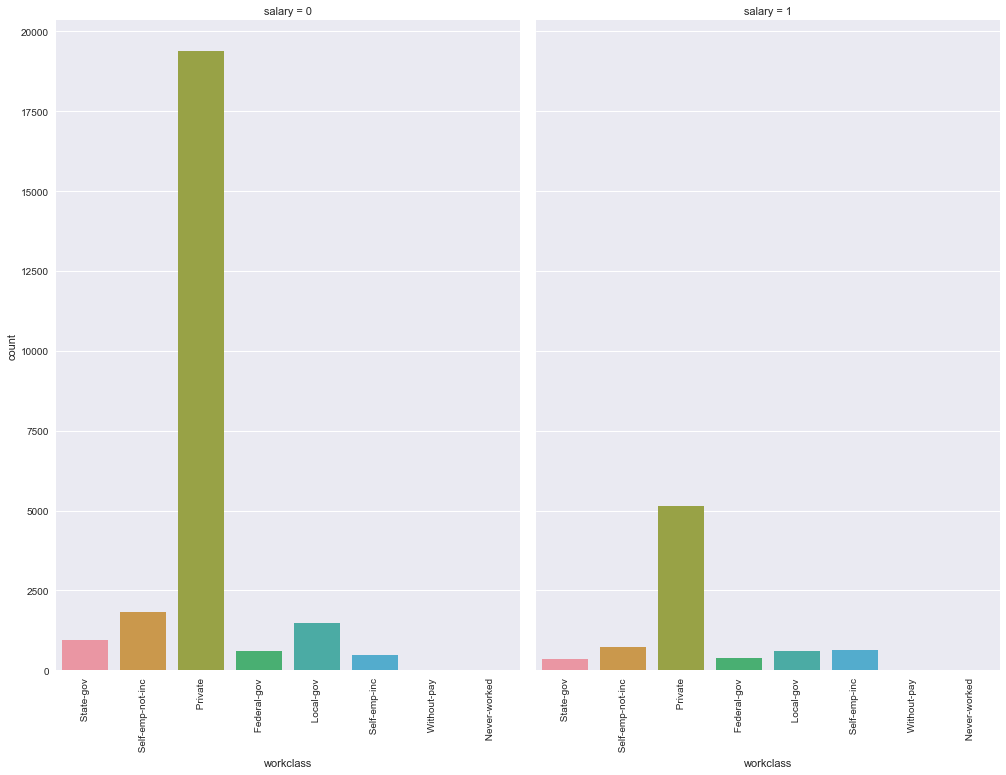

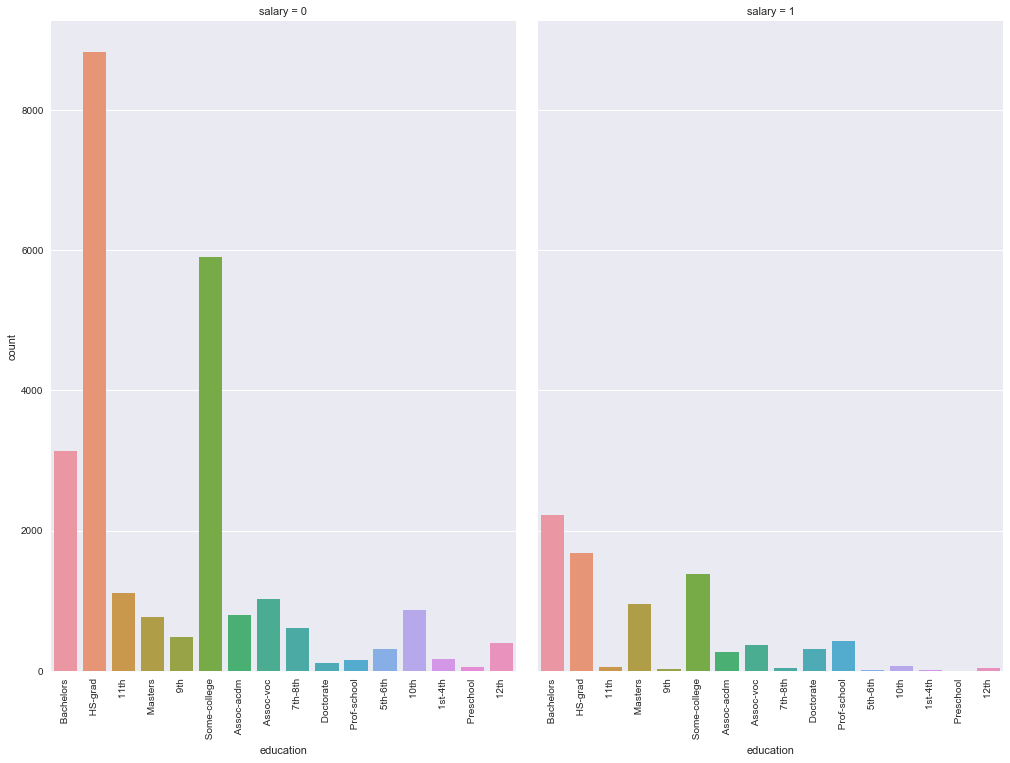

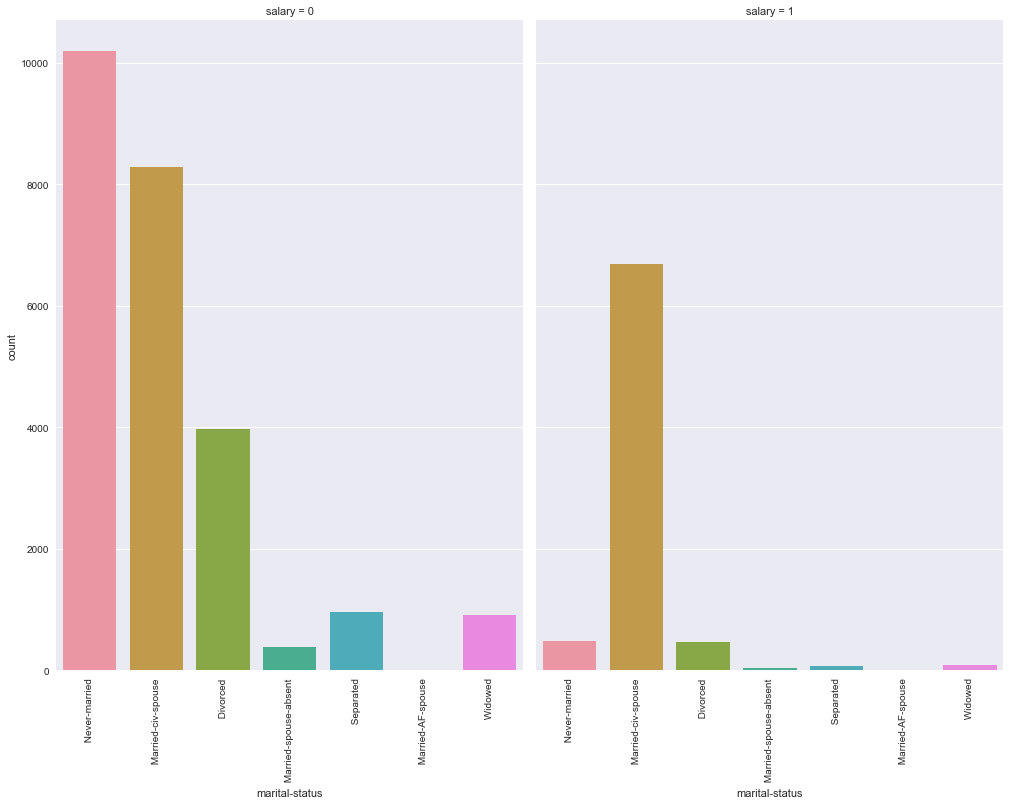

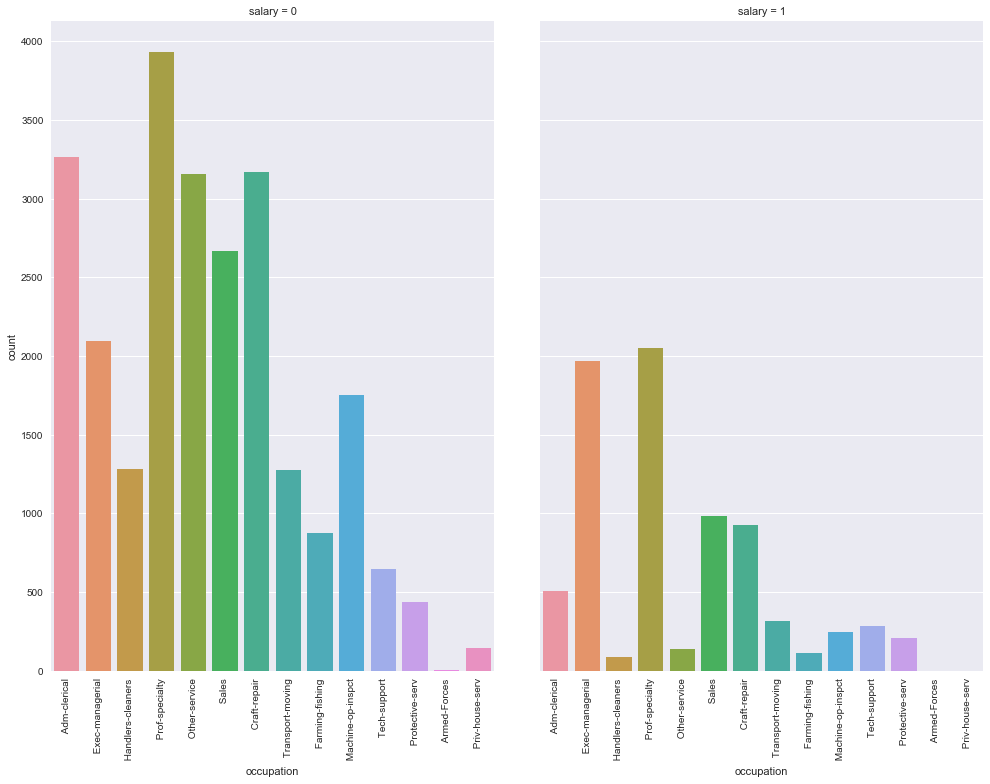

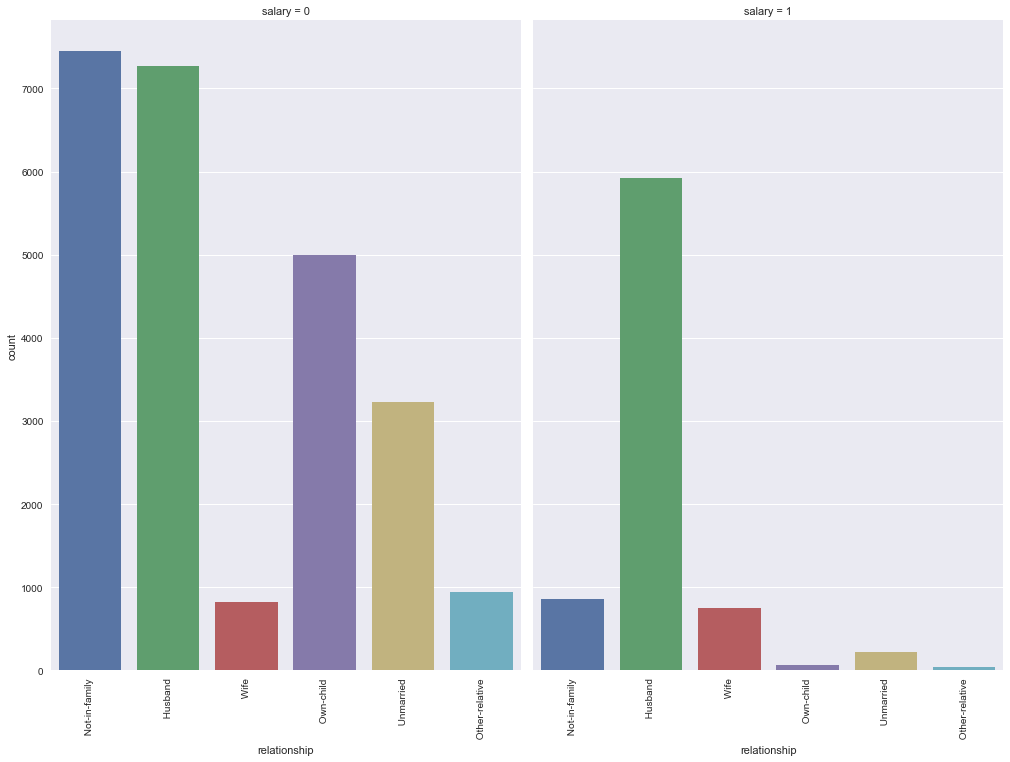

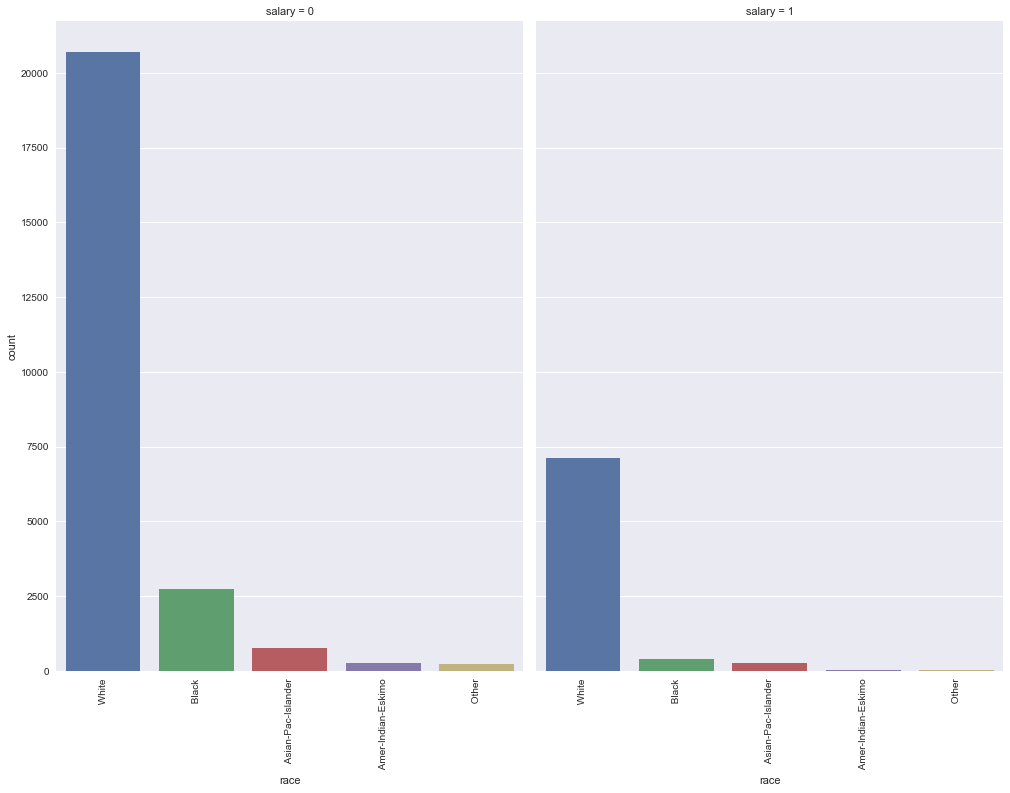

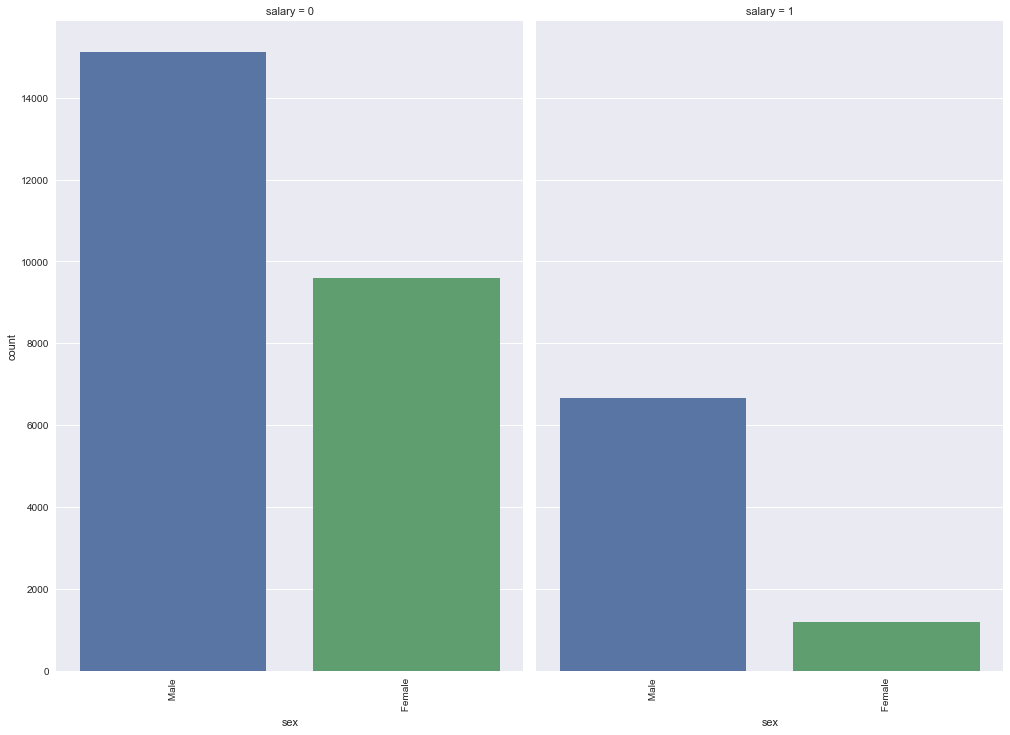

In [328]:
import seaborn as sns
names = adult_sns.loc[:, adult_sns.columns!="salary"].select_dtypes(exclude=[np.number]).columns
for name in names:
    ax=sns.factorplot(x=name, col="salary",  data=adult_sns, linewidth=1, kind="count", size=10, aspect=.7)
    ax.set_xticklabels(rotation=90)
    plt.xticks(rotation=90)
    plt.show()


## De esto Extraemos:

 * Entre las clases de la variables *workclass* notamos que en porcentaje relativo, las ocupaciones que pueden tener salario mayor a 50K, son las personas que trabajan por su cuentas (*self-employee*).
 * Como es de esperarse las persona que tienen más años de estudio, tiene los sueldos más altos (*Doctorados, master, profesores*)
 * Con respecto al estado marital, parece haber una relación negayiva entre los sueldos altos y ser soltero (*never-married, divorced, separated*)
 * Las ocupaciones mejor pagadas son: *los gerentes ejecutivos,los profesores, y profersionales en general*.
 * La personas que no están en relaciones familiares presenta menor tasa de sueldos altos, que aquellas con esposas, maridos, etc.
 * Las personas de raza blanca, tienen los mejores salarios.
 * El sexo también parece ser un indicador de un buen salario, se observa como los hombres que ganan más de 50K, son casi 5 veces que la cantidad de mujeres que ganan esa cantida.

### Para las  variables númericas:

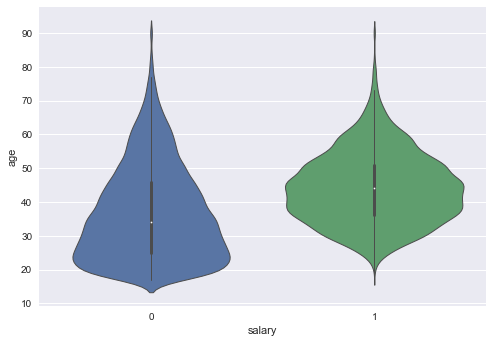

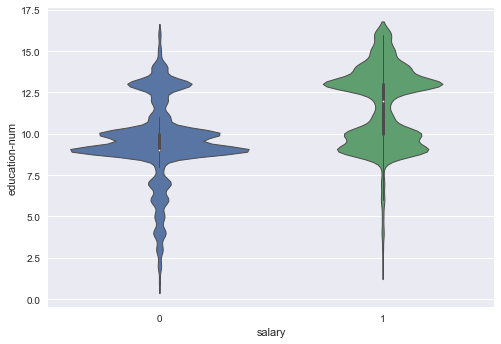

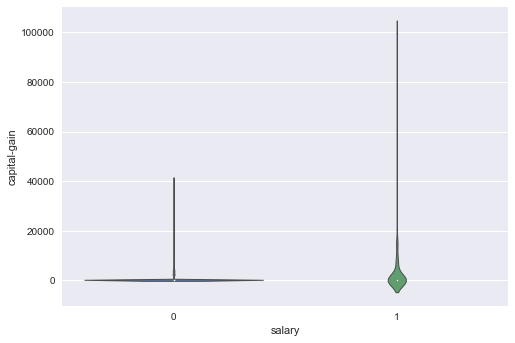

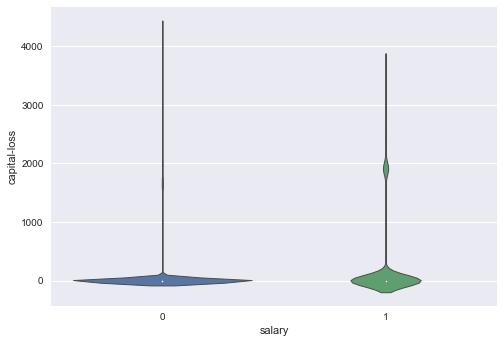

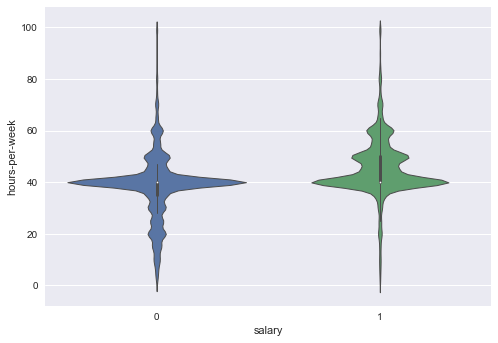

In [329]:
names = adult_sns.loc[:, adult_sns.columns!="salary"].select_dtypes(include=[np.number]).columns
for name in names:
    ax=sns.violinplot(y=name, x= "salary", data=adult_sns, linewidth=1, kind="count", size=10, aspect=.7)
    plt.show()


De los gráficos notamos:
 * Que entre 30-50 está el rango de edad de personas que gana más de 50K, con un promedio de 45 años.
 * las personas con más años de estudio ganan mucho más, es más probable que una persona con más de 12 años de estudio gane más de 50K.
 * En promedio no existe gran diferencia entre la cantidad de horas trabajadas por semana y el salario según notamos en el gráfico.

In [330]:
adult_sns.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,0


###  Ajusta y optimiza un modelo de regresión logística que te permita predecir salary en base a los predictores que consideres.

De los relaciones establecidas anteriormente seleccionaremos para nuestro primer modelo las variables: *workclass, education, marital_startus, relationship, race y sex*
de las variables númericas seleccionaremos *education-num, capital-gain y capital-loss*

### Codificando Variables  Categóricas

Utilizaremos el método <a href=http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html>**get_dummies**</a> para realizar nuestro one-hot encoding de las variables seleccionadas:

In [331]:
####### INSERT YOUR CODE HERE
from sklearn import preprocessing
workclass = pd.get_dummies(adult.workclass, prefix="wc" )
education = pd.get_dummies(adult.education, prefix="ed")
educa_num = pd.get_dummies(adult["education-num"], prefix="ed_num")
marital = pd.get_dummies(adult["marital-status"], prefix="ms")
occupation = pd.get_dummies(adult["occupation"], prefix="op")
relationship = pd.get_dummies(adult["relationship"], prefix="rl")
race = pd.get_dummies(adult["race"], prefix="rc")
sex = pd.get_dummies(adult["sex"], prefix="sex")
nc = pd.get_dummies(adult["native-country"], prefix="nc")


In [332]:
adult_dm = pd.concat([adult, workclass, education, educa_num, marital,  relationship, sex,], axis=1)
adult_dm  = adult_dm.drop(["age", "race",  "workclass","marital-status",  "education", "education-num", "occupation", "relationship", "race", "sex", "native-country", "salary", "hours-per-week" ], axis=1)
adult_dm.head()

,capital-gain,capital-loss,wc_ Federal-gov,wc_ Local-gov,wc_ Never-worked,wc_ Private,wc_ Self-emp-inc,wc_ Self-emp-not-inc,wc_ State-gov,wc_ Without-pay,...,ms_ Separated,ms_ Widowed,rl_ Husband,rl_ Not-in-family,rl_ Other-relative,rl_ Own-child,rl_ Unmarried,rl_ Wife,sex_ Female,sex_ Male
0,2174,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


We should now see that the original columns have been replaced by dummy one-hot-encoded columns:

### Missing values

Revisamos nuevamente por NA's

In [333]:
pd.isnull(adult).sum()

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64

In [334]:
assert(adult.isnull().sum().sum() == 0)

### Extraemos la variable objetivo target

De esta forma tenemos que 0 es "<=50K" y 1 el mayor que "50K"

In [335]:
salary = ((adult["salary"]) == " >50K").astype(int)

In [336]:
salary

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        1
8        1
9        1
10       1
11       1
12       0
13       0
14       1
15       0
16       0
17       0
18       0
19       1
20       1
21       0
22       0
23       0
24       0
25       1
26       0
27       1
28       0
29       0
        ..
32531    0
32532    1
32533    1
32534    0
32535    0
32536    1
32537    0
32538    1
32539    1
32540    0
32541    0
32542    0
32543    0
32544    0
32545    1
32546    0
32547    0
32548    0
32549    0
32550    0
32551    0
32552    0
32553    0
32554    1
32555    0
32556    0
32557    1
32558    0
32559    0
32560    1
Name: salary, Length: 32561, dtype: int32

### Dividimos los Datos

Dividimos los datos en test , train para probar entrenar y testear nuestro modelo

In [337]:
####### INSERT YOUR CODE HERE
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(adult_dm,salary, test_size=0.2, random_state=0)


Chequeamos:

In [338]:
X_train.head()

,capital-gain,capital-loss,wc_ Federal-gov,wc_ Local-gov,wc_ Never-worked,wc_ Private,wc_ Self-emp-inc,wc_ Self-emp-not-inc,wc_ State-gov,wc_ Without-pay,...,ms_ Separated,ms_ Widowed,rl_ Husband,rl_ Not-in-family,rl_ Other-relative,rl_ Own-child,rl_ Unmarried,rl_ Wife,sex_ Female,sex_ Male
15282,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
24870,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
18822,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
26404,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
7842,0,2149,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


In [339]:
Y_train.head()

15282    0
24870    0
18822    0
26404    0
7842     0
Name: salary, dtype: int32

In [340]:
X_test.head()

,capital-gain,capital-loss,wc_ Federal-gov,wc_ Local-gov,wc_ Never-worked,wc_ Private,wc_ Self-emp-inc,wc_ Self-emp-not-inc,wc_ State-gov,wc_ Without-pay,...,ms_ Separated,ms_ Widowed,rl_ Husband,rl_ Not-in-family,rl_ Other-relative,rl_ Own-child,rl_ Unmarried,rl_ Wife,sex_ Female,sex_ Male
22278,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
8950,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
7838,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
16505,0,1902,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
19140,0,2824,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [341]:
Y_test

22278    0
8950     0
7838     0
16505    0
19140    1
12319    0
28589    0
10000    0
28530    1
24237    0
12227    0
821      0
25012    1
24579    0
29295    0
4763     1
10371    0
6964     0
9907     0
30594    0
28635    0
28819    1
26980    1
22148    0
21840    0
15334    1
20409    0
3695     0
1523     0
14833    0
        ..
20282    0
21987    0
28072    1
9211     1
11797    1
1165     0
31726    0
26649    0
16910    1
28568    0
16662    1
6156     0
2162     0
11083    0
12974    0
25215    1
4897     1
8553     0
2817     1
12714    1
21084    0
10927    0
11452    0
28609    0
21297    0
7694     1
10410    0
1043     1
30860    0
12467    1
Name: salary, Length: 6513, dtype: int32

## Crear el modelo de regresión

Ajustamos el modelo, con el paquete sklearn

In [342]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Evaluamos nuestro modelo:

In [343]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, y_pred)
print(confusion_matrix)

[[4535  383]
 [ 672  923]]


In [344]:
### La precisión de Nuestro Modelo es:

In [345]:
print('Precisión es: {:.2f}'.format(classifier.score(X_test, Y_test)))


Precisión es: 0.84


Podemos Visualizar las Fronteras de clasificación haciendo un scatter de las componentes principales:

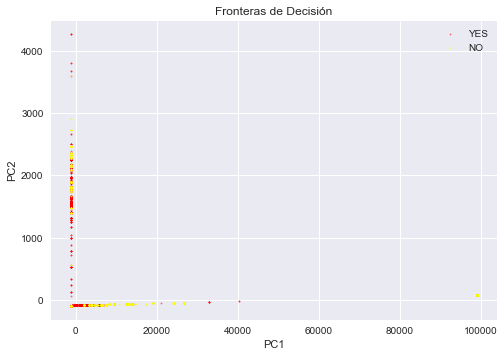

In [346]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(adult_dm)
X_train, X_test, y_train, y_test = train_test_split(pca, salary, random_state=0)

plt.scatter(pca[salary.values==0,0], pca[salary.values==0,1], alpha=0.5, label='YES', s=2, color='red')
plt.scatter(pca[salary.values==1,0], pca[salary.values==1,1], alpha=0.5, label='NO', s=2, color='yellow')
plt.legend()
plt.title('Fronteras de Decisión')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

## Evaluamos con cross Validation:

In [347]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

y_pred =  cross_validation.cross_val_predict(LogisticRegression(), adult_dm, salary, cv=10)


La métrica con CV es: 

In [348]:
print (metrics.classification_report(salary, y_pred)) 

             precision    recall  f1-score   support

          0       0.87      0.93      0.90     24720
          1       0.72      0.57      0.64      7841

avg / total       0.83      0.84      0.84     32561



Nos arroja una precisión del 83%, lo cuál no está mal, pero veamos si podemos mejorar el modelo:

### Primero Estandarizaremos los datos nùmericos

In [349]:
from sklearn import preprocessing

adult_estandar = adult.loc[:, adult.columns!="salary"].select_dtypes(include=[np.number])
#scaler.fit(df_data)
min_max_scaler = preprocessing.MinMaxScaler()
adult_estandar = min_max_scaler.fit_transform(adult_dm)
adult_estandar = pd.DataFrame(adult_estandar, columns=adult_dm.columns)
adult_estandar.head()


,capital-gain,capital-loss,wc_ Federal-gov,wc_ Local-gov,wc_ Never-worked,wc_ Private,wc_ Self-emp-inc,wc_ Self-emp-not-inc,wc_ State-gov,wc_ Without-pay,...,ms_ Separated,ms_ Widowed,rl_ Husband,rl_ Not-in-family,rl_ Other-relative,rl_ Own-child,rl_ Unmarried,rl_ Wife,sex_ Female,sex_ Male
0,0.02174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.00000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.00000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.00000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


a) Aplicamos Nuevamente  nuestro modelo:

In [350]:
X_train, X_test, Y_train, Y_test = train_test_split(adult_dm,salary, test_size=0.2, random_state=0)


In [351]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train,Y_train)
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, y_pred)
print(confusion_matrix)

[[4535  383]
 [ 672  923]]


In [352]:
print('Precisión es: {:.2f}'.format(classifier.score(X_test, Y_test)))

Precisión es: 0.84


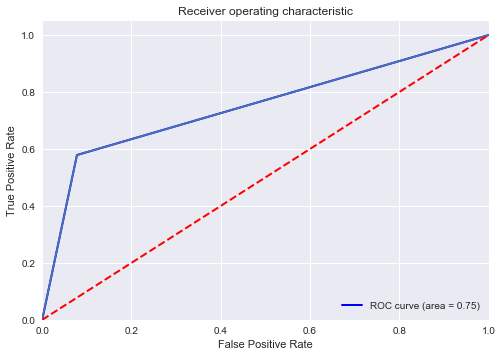

In [353]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
plt.plot(fpr[1], tpr[1], color='blue',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Introduciremos la variables *ocupation* en nuestro modelo:

In [354]:
adult_dm = pd.concat([adult, workclass, education, educa_num, marital, occupation,  relationship, sex,], axis=1)
adult_dm  = adult_dm.drop(["age", "race",  "workclass","marital-status",  "education", "education-num", "occupation", "relationship", "race", "sex", "native-country", "salary", "hours-per-week" ], axis=1)
adult_dm.head()

adult_estandar = adult.loc[:, adult.columns!="salary"].select_dtypes(include=[np.number])
#scaler.fit(df_data)
min_max_scaler = preprocessing.MinMaxScaler()
adult_estandar = min_max_scaler.fit_transform(adult_dm)
adult_estandar = pd.DataFrame(adult_estandar, columns=adult_dm.columns)
adult_estandar
X_train, X_test, Y_train, Y_test = train_test_split(adult_estandar,salary, test_size=0.2, random_state=0)
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train,Y_train)
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, y_pred)
print(confusion_matrix)
print('Precisión es: {:.2f}'.format(classifier.score(X_test, Y_test)))

[[4574  344]
 [ 681  914]]
Precisión es: 0.84


Revisamos el Resultado a través de la curva ROC:

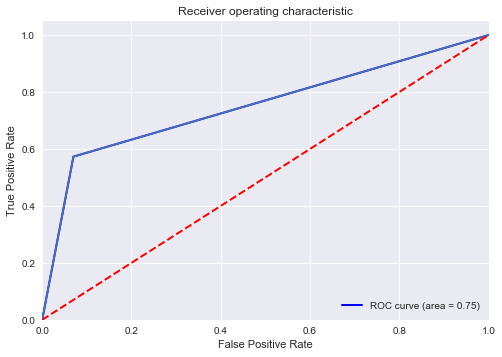

In [355]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
plt.plot(fpr[1], tpr[1], color='blue',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Observamos que la Precisión se va hasta 84%, probemos con CV

In [356]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

y_pred =  cross_validation.cross_val_predict(LogisticRegression(), adult_estandar, salary, cv=10)
print (metrics.classification_report(salary, y_pred)) 

             precision    recall  f1-score   support

          0       0.87      0.93      0.90     24720
          1       0.73      0.58      0.64      7841

avg / total       0.84      0.85      0.84     32561



Aparentemente nuestro modelo no es capaz de mejorar más allá de un 84%, según lo observado en nuestro análisis.

## En resumen:

* La regresión logística es especialmente útil en casos solo hay dos posibles respuestas
(cuando la variable de respuesta es dicotómica), por lo que se puede decir que es un modelo de clasificación binario enmarcado dentro de los **GLM**.
* Para nuestro caso se analizó el dataset de *adult*, mediante el cuál se pretendía extraer un modelo para predecir/clasificar si una determinada persona gana más de 50.000 USD al año. 
* El modelo obtenido obtiene un 84% de precisión utilizando las variables *workclass, education, marital_startus, relationship, race,sex, occupation, education-num, capital-gain y capital-loss.
* Para incremental la precision se podría tratar de implementar un modelo más complejo como: Random Forest ó SVM.
* La Curva ROC nos permite revisar el comportamiento de nuestro modelo desde el punto de vista de los *falsos, verdaderos positivos*, en nuestro caso no varía en gran medida, esta curva es especialmente util en los casos cuando debemos comparar varios clasificadores distintos.